In [36]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import spaces

class SDEEnv_train(gym.Env):
    """ will remove the stoichastic part of the system """
    def __init__(self):
        super(SDEEnv_train, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        
        # Actions are [u1, u2], both in some control range
        self.action_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        self.state = np.array([1, 1])  # You can set this based on the problem
        
    def reset(self,seed = None,options = None):
        # Reset the state to initial values
        self.state = np.array([0.1, 0.1]) #initial value can be changed, the bigger the value helps the model, but 0 is optimal
        
        return self.state

    def step(self, action):
        u1, u2 = action
        y1, y2 = self.state
        
        dt = self.dt
        
        # Deterministic part of the system (first equation)
        #dy1 = -(u1 + 0.5 * u1**2 * y1 + 0.5 * u2 * y2 / (y1 + y2)) * dt
        dy1 = ( -1*(u1 + 0.5 * u1**2 )* y1 + 0.5 * u2 * y2 / (y1 + y2)) * dt

        # Stochastic part of the second equation
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener process for stochastic term
        dy2 = (u1 * y1 - 0.7 * u2 * y1) * dt + (0.1 * np.sqrt(y1)) 
        
        
        # Update states
        y1 += dy1
        y2 += dy2
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state = np.array([y1, y2])
        
        # Reward is based on maximizing y2
        reward = y2*10
        
        # Done if the system has run too long or if values go out of bounds
        done = False
        if y1 < .01 or y2 < .01:
            reward = -1000
            done = True
        
        return self.state, reward, done, False, {}

    def render(self):
        # Optional rendering for visualization, not essential
        print(f"State: y1={self.state[0]}, y2={self.state[1]}")


In [78]:

class SDEEnv_train_2(gym.Env):
    """ nothing will change ,expcep that its stoichastic """
    def __init__(self):
        super(SDEEnv_train_2, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        
        # Actions are [u1, u2], both in some control range
        self.action_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        self.state = np.array([1, 1])  
        
    def reset(self,seed = None,options = None):
        # Reset the state to initial values
        self.state = np.array([0.1, 0.1])
        return self.state

    def step(self, action):
        u1, u2 = action
        y1, y2 = self.state
        
        dt = self.dt
        
        # Deterministic part of the system (first equation)
        dy1 = ( -1*(u1 + 0.5 * u1**2 )* y1 + 0.5 * u2 * y2 / (y1 + y2) ) * dt
        
        # Stochastic part of the second equation
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener process for stochastic term
        dy2 = (u1 * y1 - 0.7 * u2 * y1) * dt + (0.1 * np.sqrt(y1) ) * dW
        
        
        # Update states
        y1 += dy1
        y2 += dy2
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state = np.array([y1, y2])
        
        # Reward is based on maximizing y2
        reward = y2*100
        
        # Done if the system has run too long or if values go out of bounds
        done = False
        if y1 < 0 or y2 < 0:
            reward = -1000
            done = True
        
        return self.state, reward, done, False, {}

    def render(self):
        # Optional rendering for visualization, not essential
        print(f"State: y1={self.state[0]}, y2={self.state[1]}")


In [39]:
import numpy as np
from scipy.integrate import solve_ivp

class SDEEnv_train_2_test(gym.Env):
    """Env with ODE solver for y1 and y2, and stochasticity added after solving the ODE."""
    
    def __init__(self):
        super(SDEEnv_train_2_test, self).__init__()
        
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        
        # Actions are [u1, u2], both in some control range
        self.action_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        self.state = np.array([1, 1])  
    
    def reset(self, seed=None, options=None):
        # Reset the state to initial values
        self.state = np.array([0.1, 0.1])
        return self.state

    def odes(self, t, state, u1, u2):
        """Defines the system of ODEs to be solved."""
        y1, y2 = state
        
        # Deterministic part of the system (ODEs)
        dy1 = -1 * (u1 + 0.5 * u1**2) * y1 + 0.5 * u2 * y2 / (y1 + y2)
        dy2 = u1 * y1 - 0.7 * u2 * y1
        
        return [dy1, dy2]

    def step(self, action):
        u1, u2 = action
        y1, y2 = self.state
        dt = self.dt

        # Solve the ODE system for the next time step using solve_ivp
        sol = solve_ivp(self.odes, [0, dt], [y1, y2], args=(u1, u2), method='RK45')
        
        # Get the updated states from the solver
        y1_new, y2_new = sol.y[:, -1]  # Final values at t = dt
        
        # Calculate reward after solving the deterministic ODEs
        if y2_new<0.7:
            reward=-5
        else:
            reward = y2_new * 10  # Reward based on the deterministic value of y2
      # Reward based on the deterministic value of y2
        
        # Add the stochastic part to y2
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener process for stochastic term
        y2_new += 0.1 * np.sqrt(max(0, y1_new)) * dW  # Apply stochastic effect only to y2
        
        # Update the states in the environment
        self.state = np.array([y1_new, y2_new])
        
        # Done if the system has run too long or if values go out of bounds
        done = False
        
        if y1_new < 0 or y2_new < 0:
            reward = -1000
            done = True
        
        return self.state, reward, done, False, {}

    def render(self):
        # Optional rendering for visualization, not essential
        print(f"State: y1={self.state[0]}, y2={self.state[1]}")


In [36]:
enviorment=SDEEnv_train_2()

In [33]:
import gymnasium as gym 


In [66]:
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv

# Define your custom environment or choose an appropriate gym environment
# For this example, we'll use a placeholder custom environmen
env=SDEEnv_train_2()
n_actions = env.action_space.shape[-1]

# Tune Ornstein-Uhlenbeck noise
ou_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.1 * np.ones(n_actions),  # Increase sigma for more exploration in stochastic systems
    theta=0.10,  # Lower theta for smoother exploration
    dt=enviorment.dt # Adjust time-step as per the environment's dynamics
)

model = DDPG(
    "MlpPolicy", 
    env, 
    buffer_size=int(128),         # Large buffer size to smooth out stochasticity
    batch_size=64,          # Larger batch size to stabilize updates
    learning_rate=1e-4,      # Slower learning rate to avoid overfitting to noise
    gamma=0.98,              # Discount factor tuned for stochastic systems
    tau=5e-4,                # Slower target network update rate for smoother training
    action_noise=ou_noise,   # Use tuned Ornstein-Uhlenbeck noise
    verbose=0
)
print("model created")




model created


In [28]:
import os

# Define the folder path
folder_path = "models"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save the model in the specified folder

for i in range(1000):
    model.learn(total_timesteps=1000)
    model.save(os.path.join(folder_path, f"ddpg_stochastic_system{i}.zip"))
    print(f"Model saved as ddpg_stochastic_system{i}.zip")
# Save the final model


NameError: name 'model' is not defined

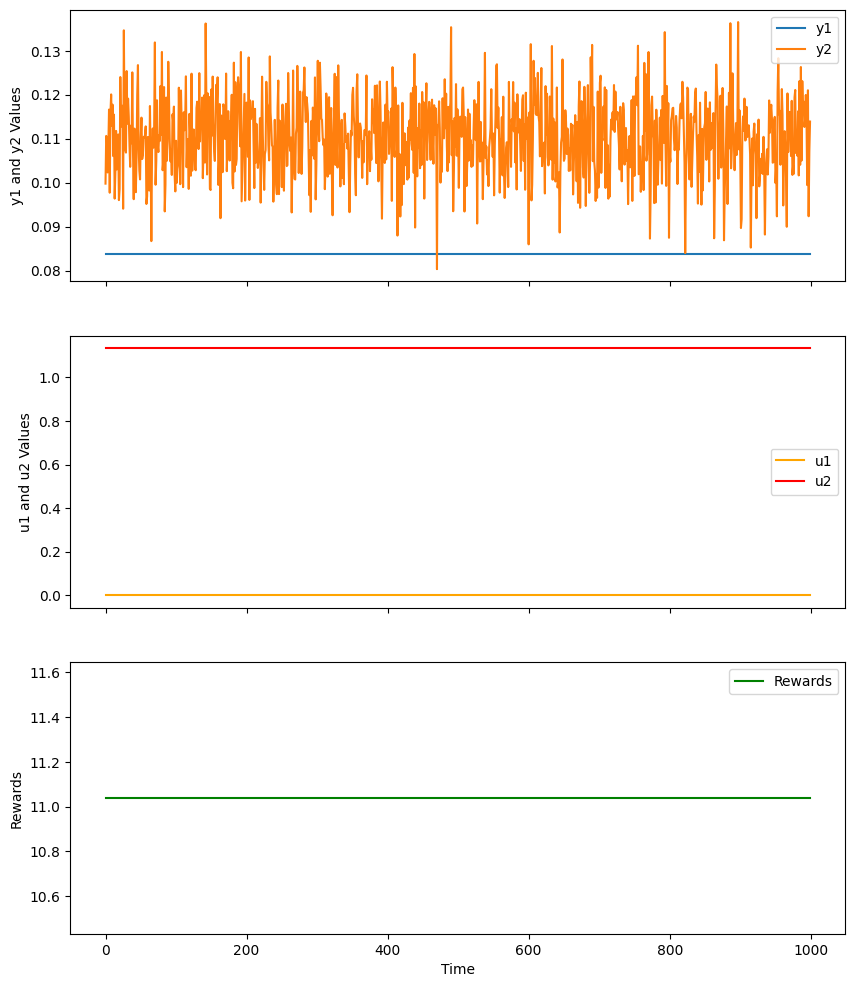

In [79]:
path=r"D:\ALL CODES\REINCEFORCEMENT LEARNING\Papers\PAPERS\chemE RL papers\deep learning for batch bioporcesss\models\ddpg_stochastic_system485.zip"
env_test=SDEEnv_train_2_test()
from stable_baselines3 import DDPG
model_trained=DDPG.load(path,env=env_test)
y1_values=[]
y2_values=[]
u1_values=[]
time=[]
u2_values=[]
rewards=[]
for t in range(1000):
    obs = env_test.reset()
    action, _states = model_trained.predict(obs)
    obs, reward, done, _, _ = env_test.step(action)
    rewards.append(reward)
    y1_values.append(obs[0])
    y2_values.append(obs[1])
    u1_values.append(action[1])
    u2_values.append(action[0])
    time.append(t)


# Plot the results
import matplotlib.pyplot as plt

# Assuming you have the rewards data in a variable called rewards
# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot y1 and y2 in the first subplot
ax1.plot(time, y1_values, label='y1')
ax1.plot(time, y2_values, label='y2')
ax1.set_ylabel('y1 and y2 Values')
ax1.legend()

# Plot u1 and u2 in the second subplot
ax2.plot(time, u1_values, label='u1', color='orange')
ax2.plot(time, u2_values, label='u2', color='red')
ax2.set_ylabel('u1 and u2 Values')
ax2.legend()

# Plot rewards in the third subplot
ax3.plot(time, rewards, label='Rewards', color='green')
ax3.set_xlabel('Time')
ax3.set_ylabel('Rewards')
ax3.legend()

# Show the plot
plt.show()

#2ND TRAINING PHASE, THIS TIME USING A ODE SOLVER AND ALSO A GREATER LERANING RATE , ALSO HAS NEGETIVE REWARD ?
Model might be made  determininstc ? (so no, ode solver is only feasible for testing phase, since it works good enough for training)

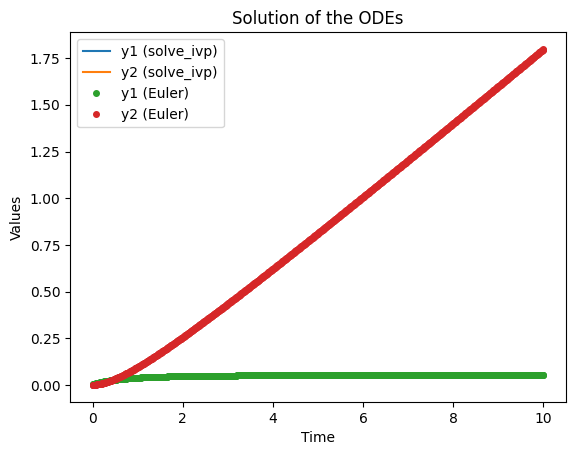

In [77]:
# ODE solve just to test the action space is working or not

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def odes(t, y, u1, u2):
    y1, y2 = y
    dy1 = -1 * (u1 + 0.5 * u1**2) * y1 + 0.5 * u2 * y2 / (y1 + y2)
    dy2 = u1 * y1 - 0.7 * u2 * y1
    return [dy1, dy2]

# Initial conditions
y0 = [0.001, 0.001]

# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Control inputs
u1 = 5
u2 = 2

# Solve the ODEs using solve_ivp
sol = solve_ivp(odes, t_span, y0, args=(u1, u2), t_eval=t_eval)

# Euler method implementation
dt = .01
t_euler = np.arange(t_span[0], t_span[1] + dt, dt)
y_euler = np.zeros((2, len(t_euler)))
y_euler[:, 0] = y0

for i in range(1, len(t_euler)):
    dy = odes(t_euler[i-1], y_euler[:, i-1], u1, u2)
    y_euler[:, i] = y_euler[:, i-1] + np.array(dy) * dt

# Plot the results
plt.plot(sol.t, sol.y[0], label='y1 (solve_ivp)')
plt.plot(sol.t, sol.y[1], label='y2 (solve_ivp)')
plt.plot(t_euler, y_euler[0], 'o', label='y1 (Euler)', markersize=4)
plt.plot(t_euler, y_euler[1], 'o', label='y2 (Euler)', markersize=4)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the ODEs')
plt.show()

In [119]:

class SDEEnv_train_3(gym.Env):
    """ stochasticity added ,also tuned the rewards more, and also has a fixed episode length"""
    def __init__(self):
        super(SDEEnv_train_3, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        
        # Actions are [u1, u2], both in some control range
        self.action_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        self.state = np.array([1, 1])
        self.episode_length = 1000  # Maximum episode length
        self.current_step= 0
        
    def reset(self,seed = None,options = None):
        # Reset the state to initial values
        self.state = np.array([0.01, 0.01])
        self.current_step = 0
        return self.state

    def step(self, action):
        u1, u2 = action
        y1, y2 = self.state
        
        dt = self.dt
        
        # Deterministic part of the system (first equation)
        dy1 = ( -1*(u1 + 0.5 * u1**2 )* y1 + 0.5 * u2 * y2 / (y1 + y2) ) * dt
        
        # Stochastic part of the second equation
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener process for stochastic term
        dy2 = (u1 * y1 - 0.7 * u2 * y1) * dt + (0.1 * np.sqrt(y1) ) * dW
        
        
        # Update states
        y1 += dy1
        y2 += dy2
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state = np.array([y1, y2])
        
        # Reward is based on maximizing y2
        if y2<0.3:
            reward= -2 + y2*10
        else:
            reward = y2*10       
        # Done if the system has run too long or if values go out of bounds
        done = False
        
        if y1 < 0 or y2 < 0:
            reward = -1000
            done = True
            
        self.current_step += 1
        
        if self.current_step >= self.episode_length:
            done = True
        
        #so terminate when exceeds episode length 
        
        return self.state, reward, done, False, {}

    def render(self):
        # Optional rendering for visualization, not essential
        print(f"State: y1={self.state[0]}, y2={self.state[1]}")


In [120]:
path=r"D:\ALL CODES\REINCEFORCEMENT LEARNING\Papers\PAPERS\chemE RL papers\deep learning for batch bioporcesss\models2\V2_ddpg_stochastic_system120.zip"
modelV2=DDPG.load(path,env=SDEEnv_train_3())
#i should increase the learning rate by ? 100 times
modelV2.actor.optimizer.param_groups[0]['lr']=1e-1
modelV2.critic.optimizer.param_groups[0]['lr']=1e-1               
print(f"model loaded with learning rate {modelV2.actor.optimizer.param_groups[0]['lr']}")
#modelV2.action_noise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

new_mu = np.array([3 , 3]) 
new_sigma = np.array([1 ,1 ]) 


# Create a new Ornstein-Uhlenbeck noise object with the new parameters
new_ou_noise = OrnsteinUhlenbeckActionNoise(
    mean=new_mu,
    sigma=new_sigma,
    theta=0.15,  # You can also change theta if needed
    dt=.1  # Use the same dt as the original noise
)

# Assign the new noise object to the model
modelV2.action_noise = new_ou_noise


model loaded with learning rate 0.1


In [121]:
import datetime
import os
from IPython.display import clear_output

env = SDEEnv_train_3()
folder = "models2"
os.makedirs(folder, exist_ok=True)

for i in range(120,1000):
    clear_output(wait=True)

    time = datetime.datetime.now()

    modelV2.learn(total_timesteps=1000)
    modelV2.save(os.path.join(folder, f"V2_ddpg_stochastic_system{i}.zip"))
    time2 = datetime.datetime.now()
    time_diff = time2 - time
    print(f"Model saved as V2_ddpg_stochastic_system{i}.zip, it took time {time_diff.total_seconds()} seconds")
    
    #maybe i should plot here 
    y1_values=[]
    y2_values=[]
    u1_values=[]
    time=[]
    u2_values=[]
    rewards=[]
    
    
    
    for t in range(10):
        obs = env.reset()
        action, _states = modelV2.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)
        y1_values.append(obs[0])
        y2_values.append(obs[1])
        u1_values.append(action[1])
        u2_values.append(action[0])
        time.append(t)


    # Plot the results

    # Assuming you have the rewards data in a variable called rewards
    # Create a figure and three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

    # Plot y1 and y2 in the first subplot
    ax1.plot(time, y1_values, label='y1')
    ax1.plot(time, y2_values, label='y2')
    ax1.set_ylabel('y1 and y2 Values')
    ax1.legend()

    # Plot u1 and u2 in the second subplot
    ax2.plot(time, u1_values, label='u1', color='orange')
    ax2.plot(time, u2_values, label='u2', color='red')
    ax2.set_ylabel('u1 and u2 Values')
    ax2.legend()

    # Plot rewards in the third subplot
    ax3.plot(time, rewards, label='Rewards', color='green')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Rewards')
    ax3.legend()

    # Show the plot
    plt.show()
    
    
    

KeyboardInterrupt: 

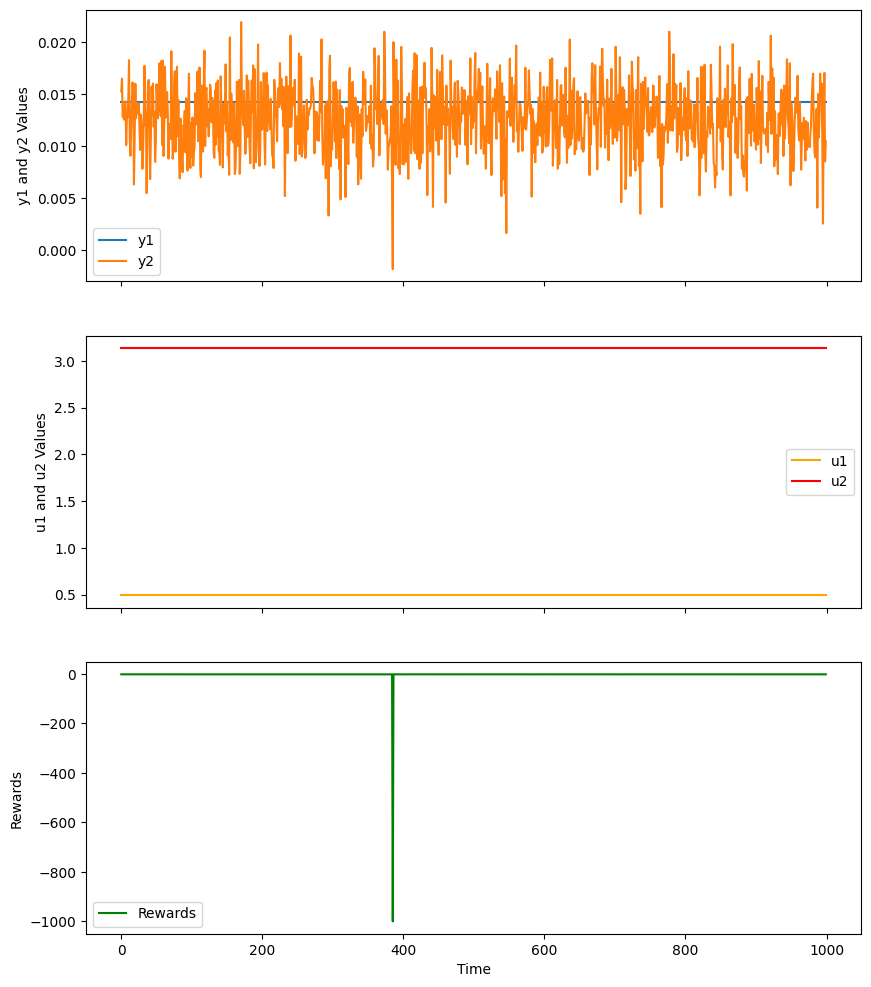

In [123]:
path="D:\ALL CODES\REINCEFORCEMENT LEARNING\Papers\PAPERS\chemE RL papers\deep learning for batch bioporcesss\models2\V2_ddpg_stochastic_system60.zip"
env_test=SDEEnv_train_3()
from stable_baselines3 import DDPG
model_trained=DDPG.load(path,env=env_test)
y1_values=[]
y2_values=[]
u1_values=[]
time=[]
u2_values=[]
rewards=[]
for t in range(1000):
    obs = env_test.reset()
    action, _states = model_trained.predict(obs)
    obs, reward, done, _, _ = env_test.step(action)
    rewards.append(reward)
    y1_values.append(obs[0])
    y2_values.append(obs[1])
    u1_values.append(action[1])
    u2_values.append(action[0])
    time.append(t)


# Plot the results
import matplotlib.pyplot as plt

# Assuming you have the rewards data in a variable called rewards
# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# Plot y1 and y2 in the first subplot
ax1.plot(time, y1_values, label='y1')
ax1.plot(time, y2_values, label='y2')
ax1.set_ylabel('y1 and y2 Values')
ax1.legend()

# Plot u1 and u2 in the second subplot
ax2.plot(time, u1_values, label='u1', color='orange')
ax2.plot(time, u2_values, label='u2', color='red')
ax2.set_ylabel('u1 and u2 Values')
ax2.legend()

# Plot rewards in the third subplot
ax3.plot(time, rewards, label='Rewards', color='green')
ax3.set_xlabel('Time')
ax3.set_ylabel('Rewards')
ax3.legend()

# Show the plot
plt.show()